In [1]:
import tensorflow as tf

In [2]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/home/dell/.local/lib/python3.8/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
t=tf.zeros([2,2,])
print(t)

tf.Tensor(
[[0. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


In [4]:
t=tf.reshape(t,4)

In [5]:
t

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>

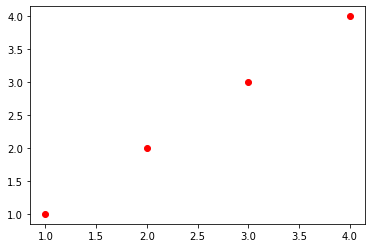

In [6]:
import matplotlib.pyplot as plt
x=[1,2,3,4]
y=[1,2,3,4]
plt.plot(x,y,'ro')

In [7]:
!pip install -q sklearn

In [8]:
import sklearn

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf


## Linear Regression example

In [10]:
# Importing dataset for linear regression
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
#dftrain.head()
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [11]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64

In [12]:
print(dftrain["age"])

0      22.0
1      38.0
2      26.0
3      35.0
4      28.0
       ... 
622    28.0
623    25.0
624    19.0
625    28.0
626    32.0
Name: age, Length: 627, dtype: float64


In [13]:
print(dftrain.loc[2], y_train.loc[2])

sex                        female
age                            26
n_siblings_spouses              0
parch                           0
fare                        7.925
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 2, dtype: object 1


In [14]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [15]:
dftrain.shape

(627, 9)

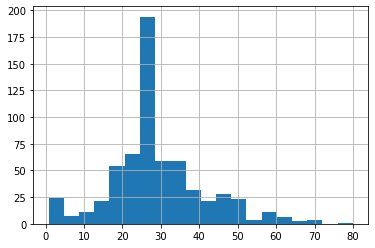

In [16]:
dftrain.age.hist(bins=20)

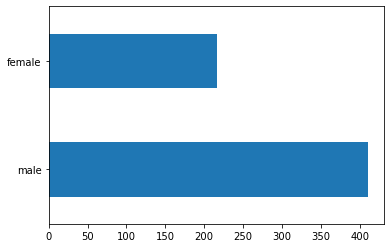

In [17]:
dftrain.sex.value_counts().plot(kind='barh')

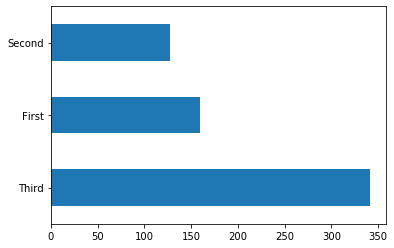

In [18]:
dftrain['class'].value_counts().plot(kind='barh')

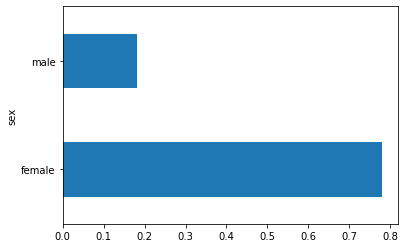

In [19]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

In [20]:
dfeval.shape

(264, 9)

In [21]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [22]:
dftrain["sex"].unique()

array(['male', 'female'], dtype=object)

In [23]:
dftrain["embark_town"].unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

In [24]:
## INput fucnction so that the data that we pass comes in as tf.data.Dataset object
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)



### Creating the model

In [25]:
linear_est=tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsaqtyajn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training the model

In [26]:
linear_est.train(train_input_fn)
result=linear_est.evaluate(eval_input_fn)
clear_output()
print(result['accuracy'])

0.75757575


In [27]:
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.8309152, 'auc_precision_recall': 0.774968, 'average_loss': 0.4812642, 'label/mean': 0.375, 'loss': 0.47281185, 'precision': 0.6635514, 'prediction/mean': 0.3910208, 'recall': 0.7171717, 'global_step': 200}


In [28]:
result=list(linear_est.predict(eval_input_fn))
print(y_eval.loc[3])
print(result[0]['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsaqtyajn/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1
[0.9406343 0.0593657]


## Classification

In [29]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [30]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [31]:
train.head()
train.shape

(120, 5)

In [32]:
train_y= train.pop('Species')
test_y=test.pop('Species')
test.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,5.9,3.0,4.2,1.5
1,6.9,3.1,5.4,2.1
2,5.1,3.3,1.7,0.5
3,6.0,3.4,4.5,1.6
4,5.5,2.5,4.0,1.3


In [33]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)


In [34]:
my_feature_columns=[]
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


### Building the model

In [35]:
# Build a DNN with two hidden layers with 30 and 10 hidden nodes each
classifier= tf.estimator.DNNClassifier(feature_columns=my_feature_columns,
                                       hidden_units=[30,10],
                                       n_classes=3
                                       )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkrgmtvdd', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training the model

In [36]:
classifier.train(input_fn=lambda: input_fn(train, train_y, training= True),
                 steps=5000
                )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpkrgmtvdd/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.7819147, step = 0
INFO:tensorflow:global_step/sec: 274.81
INFO:tensorflow:loss = 1.1300496, step = 100 (0.366 sec)
INFO:tensorflow:global_step/sec: 374.718
INFO:tensorflow:loss = 1.0431657, step = 200 (0.268 sec)
INFO:tensorflow:global_step/sec: 250.162
INFO:tensorflow:loss = 0.99502486, step = 300 (0.401 sec)
INFO:tensorflow:global_step/sec: 307.181
INFO:tensorflow:loss = 0.96624833, step = 400 (0.323 sec)
INFO:tensorflow:global_step/sec: 304.399
INFO:tensorflow:loss = 0.93606186, step = 500 (0.330 sec)
INFO

In [37]:
eval_result= classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-10-07T21:39:14Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpkrgmtvdd/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.26410s
INFO:tensorflow:Finished evaluation at 2021-10-07-21:39:14
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.53333336, average_loss = 0.6003492, global_step = 5000, loss = 0.6003492
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpkrgmtvdd/model.ckpt-5000

Test set accuracy: 0.533



## Neural network with tensorflow

In [38]:
from tensorflow import keras

In [39]:
fashion_mnist= keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels)= fashion_mnist.load_data()

In [40]:
train_images.shape

(60000, 28, 28)

In [41]:
train_images[0,23,23]

194

In [42]:
train_labels[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [43]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

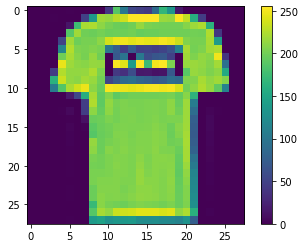

In [44]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

### Data Preprocessing

In [45]:
train_images=train_images/255.0
test_images=test_images/255.0

### Building the model

In [46]:
model= keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    
)

### Training the model

In [47]:
model.fit(train_images, train_labels, epochs=1)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.6284 - accuracy: 0.7841


In [48]:
test_loss, test_acc= model.evaluate(test_images, test_labels, verbose=1)
print('Test Accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.4440 - accuracy: 0.8331
Test Accuracy: 0.8331000208854675


In [49]:
predictions=model.predict(test_images)

In [50]:
test_images.shape

(10000, 28, 28)

In [51]:
print(predictions)

[[1.03605107e-05 7.63277512e-07 2.39343644e-05 ... 4.91087250e-02
  1.71957968e-03 9.14309025e-01]
 [8.28883058e-05 5.14142187e-07 9.46791232e-01 ... 1.22501598e-09
  3.70668677e-05 9.60875735e-09]
 [5.47780655e-06 9.99945045e-01 3.47469404e-06 ... 1.62031999e-09
  1.61212952e-07 2.37107578e-09]
 ...
 [1.83744244e-02 1.01401811e-05 8.71448079e-04 ... 4.42279779e-05
  9.13902819e-01 7.48169396e-06]
 [1.02264212e-05 9.99477446e-01 6.64788831e-06 ... 7.60133432e-08
  5.55526242e-07 4.35574975e-07]
 [1.87446922e-03 3.61954677e-04 4.58893692e-03 ... 1.02492385e-01
  3.78727242e-02 1.12351412e-02]]


In [61]:
print(class_names[np.argmax(predictions[200])])

Trouser


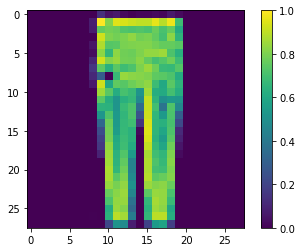

In [62]:
plt.figure()
plt.imshow(test_images[200])
plt.colorbar()
plt.grid(False)
plt.show()

Pick a number: 1


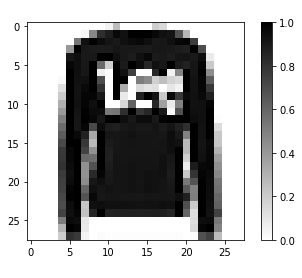

In [71]:
import matplotlib.pyplot as plt

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
      class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
      prediction = model.predict(np.array([image]))
      predicted_class = class_names[np.argmax(prediction)]

      show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
      plt.figure()
      plt.imshow(img, cmap=plt.cm.binary)
      plt.title("Excpected: " + label)
      plt.xlabel("Guess: " + guess)
      plt.colorbar()
      plt.grid(False)
      plt.show()

    
def get_number():
          while True:
            num = input("Pick a number: ")
            if num.isdigit():
              num = int(num)
              if 0 <= num <= 1000:
                return int(num)
            else:
              print("Try again...")

num = get_number()
image = test_images[num]
label = test_labels[num]
predict(model, image, label)


## Reinforcement learning with tensorflow